In [3]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import numpy as np
from nltk.stem import PorterStemmer,SnowballStemmer,LancasterStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pickle as pickle
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score , GridSearchCV , RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn import cluster
from sklearn.feature_extraction import text
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import PCA , TruncatedSVD
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import RidgeClassifier
import scipy.spatial.distance as scdist
from sklearn.metrics import accuracy_score

# Carregar o dicionario dos dados treinados

Inicialmente, a partir do ficheiro pickle são carregados os diferentes objectos do dicionário. Objetos do dicionario:

1. tfidf - Representação tf-idf com os dados treinados.
2. binClassLogReg - Classificador logistic Regression binário já treinado.
3. multiClassLogReg - Classificador logistic Regression multi-classe já treinado.
4. binClassBernoulli - Classificador naive bayes Bernoulli binário já treinado.
5. multiClassRidge - Classificador Ridge multi-classe já treinado.
6. dicMostImportantWords - Dicionário com as palavras mais importantes para diferentes clusters obtidos, para 30 clusters no processo de clustering.





In [4]:
#carregar keys do dicionário do pickle
dic = pickle.load( open( "C:/Users/duart/OneDrive/Ambiente de Trabalho/ISEL/AA/A45140Projeto/dictionary_aa_45140.p", "rb" ) )

#dictionary_aa_45140 = {'tfidf':tfidf,'binClassLogReg':binClass,'multiClassLogReg':dlMulti,'binClassBernoulli':binClassBernoulli,'multiClassRidge':multiClassRidge}
#dictionary_aa_45140 = {'tfidf':tfidfdic,'binClassLogReg':binClass,'multiClassLogReg':dlMulti}

tfidf = dic['tfidf']
binClassLogReg = dic['binClassLogReg']
multiClassLogReg = dic['multiClassLogReg']
binClassBernoulli = dic['binClassBernoulli']
multiClassRidge = dic['multiClassRidge']
dicMostImportantWordsData = dic['dicMostImportantWords']

tokens = tfidf.get_feature_names() #tokens


## Carregar listas de palavras a serem removidas no processo de pre-processamento de texto

No processo de classificação não foram removidas palavras de uma lista em especifico.

Porém, No processo de pre-processamento de texto para o clustering removeram-se as stop words, devido a estas não trazerem qualquer beneficio para separar os dados por grupos.

Foram removidas um grupo de palavras, que apareciam regularmente nas palavras mais relevantes no cluster, porém, não adicionavam nenhum beneficio para separar os dados por grupos.

In [5]:
StopWords = text.ENGLISH_STOP_WORDS #frozen set das stop words da linguagem inglesa

listStopWords = list(StopWords) #converter de frozen set para lista

#lista de palavras para serem removidas no processo de stemming
unwantedWords = ['film','movi','like','make','watch','realli','just','act','seen','plot','time','scene','end','look','actor','don','think']



Esta função faz a limpeza do texto, retirando carateres não desejados e removendo o número de feautures. 

No caso do argumento clustering for True, é feita a remoção de palavras das listas referidas acima  para o clustering.

In [6]:
def clearText(docs,stemType="PorterStemmer",clustering = False):
    
    stemFunc = None
    

    # TIPOS DE STEMMING
    if (stemType == "snowballStemmer"):
        stemFunc = SnowballStemmer('english')
    
    elif(stemType == "PorterStemmer"):
        stemFunc = PorterStemmer()
        
    elif (stemType == "LancasterStemmer"):
        stemFunc = LancasterStemmer()
        
        
    #LIMPAR ESPAÇOS
    docsPreProcessed =[i.replace('<br />',' ') for i in docs]
    
    
    
    if (clustering == True):
        
        #REMOVER AS STOP WORDS
        docsPreProcessed= [' '.join(filter(lambda x: x.lower() not in listStopWords  ,  d.split()))for d in docsPreProcessed]
        
        #REMOVER CARATERES NAO DESEJADOS, MANTER A - Z, numeros e ^
        docsPreProcessed =[re.sub(r"[^a-zA-Z'\u00C0-\u00FF]+",' ',doc) for doc in docsPreProcessed]
    
        #REALIZAR STEMMING
        docsPreProcessed =[' '.join([stemFunc.stem(w) for w in d.split()]) for d in docsPreProcessed]
        
        #REMOVER PALAVRAS QUE NAO SAO UTEIS PARA O PROCESSO DE STEMMING DA lista unwantedWords defenida em cima
        docsPreProcessed= [' '.join(filter(lambda x: x.lower() not in unwantedWords  ,  d.split()))for d in docsPreProcessed]
        
       

    
    else :
        #REMOVER CARATERES NAO DESEJADOS, MANTER A - Z, numeros e ^
        docsPreProcessed =[re.sub(r"[^a-zA-Z0-9'\u00C0-\u00FF]+",' ',doc) for doc in docsPreProcessed]
        
        #REALIZAR STEMMING
        docsPreProcessed =[' '.join([stemFunc.stem(w) for w in d.split()]) for d in docsPreProcessed]
        
    return docsPreProcessed
    
        
        
    
    
    



Esta Função  converte uma lista de strings na representação tfidf. 

Função utiliza um modelo tf-idf previamente treinado.

Retorna uma matriz documento/termo (matrizX).



In [7]:
def text2vector(docs):
    
    
    #limpeza dos docs
    docsProcessed = clearText(docs)
    
    #matriz documento / termo
    X=tfidf.transform(docsProcessed) 
    
    
    return X

Transformar o y para binario, y quando for superior a 6 é positivo, quando for inferior a 5 é negativo. Apôs isto pode ser realizada a classificação binária.

In [8]:
def transformYtoBinary(y):
    l = []
    for i in range (len(y)):
        a=0
        if y[i] > 6:
            a = 1
        else:
            a = 0
        l.append(a)
    return l



Função que retorna um array de números binários com o valor da classificação, classifica a matriz X devolvida pela função text2vector.

Esta função usa um classificador previamente treinado, se logistic for true utiliza um classificador logistico binário, se logistic for false utiliza um classificador Naive Bayes Bernoulli.

In [9]:
def binClassify(X,logistic=True):
    
    if (logistic):
        #classificador binário logistic regression treinado
        predictBin = binClassLogReg.predict(X)
    else:
        #classificador binário naive Bayes Bernoulli regression treinado
        predictBin = binClassBernoulli.predict(X)
    
    
    return predictBin
    
    

Função que retorna um array de números inteiros com o valor da classificação com valores entre (1-4) e (7-10), classifica a matriz X devolvida pela função text2vector.

Esta função usa um classificador previamente treinado, se logistic for true utiliza um classificador logistico multiclasse, se logistic for false utiliza um classificador Ridge multiclasse.

In [11]:
def multiClassify(X, logistic=True):
    
    if (logistic):
        #classificador multiclasse logistic regression treinado
        predictMulti = multiClassLogReg.predict(X)
    else:
        #classificador multiclasse Ridge treinado
        predictMulti = multiClassRidge.predict(X)
    return predictMulti
    
    

## Carregar os dados do ficheiro das criticas imbd

1. data - Conjunto de 40 000 documentos de textos de criticas de cinema 
2. target - pontuações das criticas



In [12]:
D = pickle.load( open( "C:/Users/duart/OneDrive/Ambiente de Trabalho/ISEL/AA/trabalho_pratico/imdbCriticas/imdbCriticas.p", "rb" ) )
docs = D['data']
y = D['target']



No processo de classificação os dados foram divididos em dados de treino e de teste, de forma aleatória, com 30000 amostras para treino e 10000 para teste, usando o método train_test_split do sklearn.


In [18]:
docsTrain,docsTest,yTrain,yTest = train_test_split(docs,y,test_size=1/4,shuffle=True,random_state=5)


ValueError: Found input variables with inconsistent numbers of samples: [10000, 40000]

In [ ]:
'''

docs= None

yTreino=None
yYeste= None


ybinTreino = transformYtoBinary(yTreino)
ybinTeste = transformYtoBinary(ybinTeste)

x = text2vector(docs)

predictbin = binClassify(X)
predictmulti =  multiClassify(X):


'''

Testes realizado de forma a testar o correto funcionamento dos classificadores guardados np pickle

In [14]:
#pre-processar texto
docs = clearText(docsTest) 

#Transformar os valores de y para binario
ybinTreino = transformYtoBinary(yTrain)
ybinTeste = transformYtoBinary(yTest)

#transformada tfidf
x = text2vector(docs)

#predict
predict = multiClassify(x)
accuracy = metrics.accuracy_score(yTest,predict)

#acuracy do classificador multiclasse
print(accuracy)

0.4783


In [15]:
predict = binClassify(x)

#accuracy do classificador binario
accuracyBin = metrics.accuracy_score(ybinTeste,predict)


In [16]:
print(accuracyBin)

0.9098


# Código realizado no processo de clustering

Nesta parte, irá ser apresentado o código que foi realizado no processo de clustering.

Etapas:

1. Pre-processamento dos dados com a função clear text.
2. Treinar o tfidfVectorizer e obter a matriz de documento termo X
3. Realizar PCA, com a função truncatedSVD para reduzir a dimensionalidade dos dados.
4. Obter o melhor número de clusters com a função find_best_number_clusters.
5. Realizar o clustering para o número obtido de numero de clusters iniciais.
6. Obter as palavras mais importantes dos clusters com a função getMostImportantWordsByCluster
7. Desmonstrar gráficamente as seis palavras mais importantes dos clusters com a função showTopWords




Limpar os documentos sem treino e teste

In [6]:
docsCleared=clearText(docs, clustering=True)

True


Fazer o fit tfidf

In [9]:

tfidfClustering=TfidfVectorizer(min_df=5,token_pattern=r'\b\w\w\w+\b',stop_words="english").fit(docsCleared) 

#tokens
tokens = tfidfClustering.get_feature_names() 

In [10]:
print (len(tokens))

21002


Obter a matriz de documento termo X

In [17]:
#transform tfidf sem train e test
xTransform = text2VectorTeste(docsCleared,tfidfClustering)

## Truncated SVD

Foi realizada uma análise em componente principais com 3800 componentes, uma redução da dimensionalidade dos dados para 18 porcento do tamanho original. 



In [18]:
svd = TruncatedSVD(n_components=3800)

# Como os vetores resultantantes da transformada tfidf são normalizados
# Como os resultados da SVD não são normalizados, tem que ser refeita a normalização

normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

svd_transform = lsa.fit_transform(xTransform)



soma da percentagem da variância por componente igual a cerca de 76 porcento, preserva grande parte da variância original. 

In [20]:
print("soma da percentagem da variância  por componente ",((svd.explained_variance_ratio_.sum())))

soma da percentagem da variância  por componente  0.7577029161496971


## Clustering

Realização do clustering KMeans, com um número que é obtido mais abaixo para o número de clusters.

In [40]:
#usar k means clustering
def Clustering(xTransform,n_clusters):

    km = KMeans(n_clusters , init = 'k-means++', n_init = 12, tol = 0.0001, n_jobs = 2 , algorithm = 'full', random_state=1)
    km.fit(xTransform)
   
    return km


In [41]:
kmeans = Clustering(svd_transform,30)



Clustering sparse data with KMeans(algorithm='full', n_clusters=30, n_init=12, n_jobs=2, random_state=1)


C:\Users\duart\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Done at 20:18:49


### Obter as seis palavras mais relevantes por cluster, no k means realizado.

In [42]:
def getMostImportantWordsByCluster(kmeans, n_clusters):
    
    dic = {}
   # clusters = kmeans.labels_#labels
    k_centers = kmeans.cluster_centers_  #Centros dos clusters [n_clusters, n features]
    original_space_centroids = svd.inverse_transform(k_centers) #transformar o espaco de dados de 4000 para 20278 features
    order_centroids = original_space_centroids.argsort()[:, ::-1] #inverter a ordem dos centroides ::-1

    
    for i in range(n_clusters ):
        arr=[]
        for ind in order_centroids[i, :6]:  #ir buscar as 6 palavras mais relevantes do centroide
            
          
            
            arr.append(tokens[ind])           
        
        dic[i] = arr
    
    return dic
        

In [55]:
dicMostImportantWords = getMostImportantWordsByCluster(kmeans, 30)


10488
7711
3616
7221
9837
5298
12396
14167
3918
4168
12449
3600
14066
7711
13769
17813
1662
17637
18597
16100
7711
20829
4955
13741
125
6654
7711
16310
11453
17813
6050
16327
16461
7711
3037
7866
635
2814
5127
3037
17813
20137
8806
7711
7739
16137
6431
17813
2045
15012
12886
17813
3037
140
12415
4442
17300
16882
7711
10985
20249
17257
20700
7476
17813
1420
5595
20829
16100
15229
3922
15264
20294
20714
12150
5298
18550
8799
19865
5401
1897
10656
7711
1818
20979
4549
1195
7739
8806
7711
10985
17813
1478
3037
7711
7866
7711
8071
18636
5298
13741
10232
3037
17813
7711
11222
4881
14066
1413
13724
2512
9838
18086
16461
1195
7711
20714
5298
18636
8071
10120
3184
13526
196
7711
10821
16461
6050
3037
13177
7866
7711
11837
11506
2592
12395
7711
9629
2403
11006
7711
1195
5726
17813
7221
3616
9837
7711
10488
13741
10139
16994
10138
16462
7711
12396
7866
7711
17813
1662
5974
2848
7306
14066
7836
20013
7711
10670
10715
13741
17813
10826
6425
11293
9666
18396
1059
5888
12886
19974


### Função que usa matplotlib para mostrar gráficos de barras com as palavras mais relevantes dos clusters.

In [49]:
def showTopWords(dic):
    
    arrColors = ['red','yellow','pink','blue','green','purple','brown']
    
    c=0
    
    for key in dic:
       
        if (c==7):
            c=0
        
        words = dic[key]
        y_pos = np.arange(len(words))
        
        size = len(dic)
        arr = np.arange (1,len(words)+1)
        performance = arr[::-1]
        
        plt.figure(figsize=(6,1))
        plt.bar(y_pos, performance, align='center', alpha=1,color=arrColors[c])
        c=c+1
        plt.xticks(y_pos, words)
        
        
        #plt.ylabel('Usage')
        keyS = str(key)
        title = ("Best words of  cluster "+keyS)

        plt.title(title)
        plt.show()
    
    

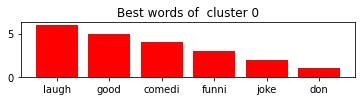

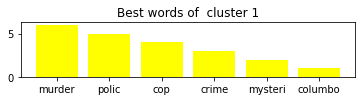

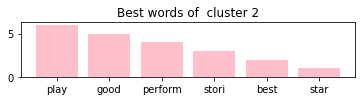

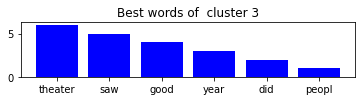

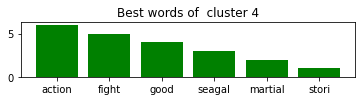

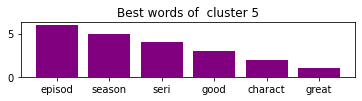

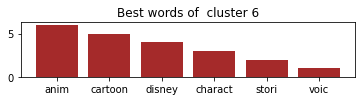

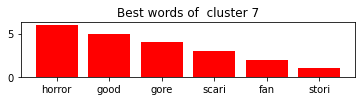

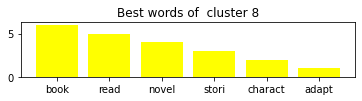

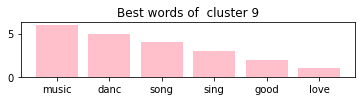

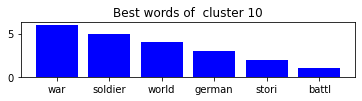

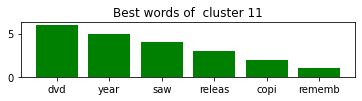

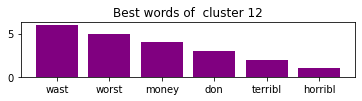

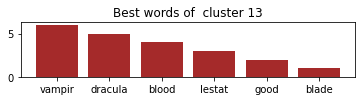

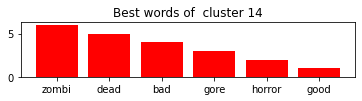

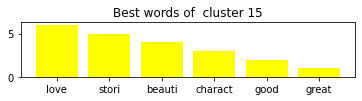

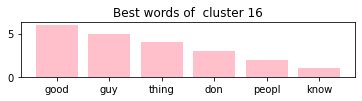

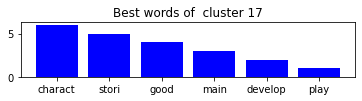

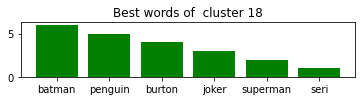

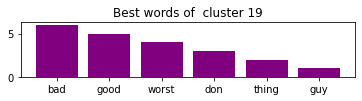

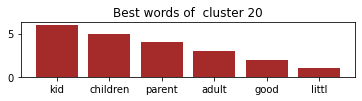

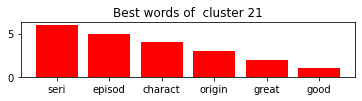

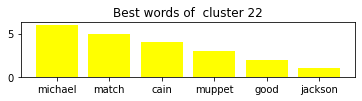

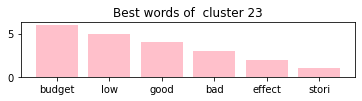

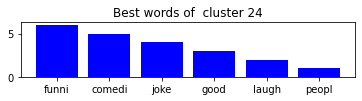

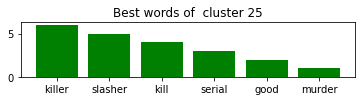

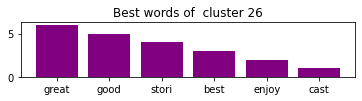

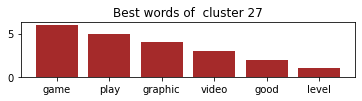

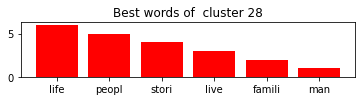

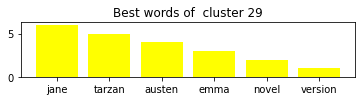

In [52]:
 showTopWords(dicMostImportantWords)

### Função para obter o melhor número de clusters

Para escolher o número inicial de k-means usou-se o método “elbow”, este método baseia-se em correr o k-means para um gama de valores de K (número de clusters) e para cada valor de K calcular a soma dos erros quadrados. 

De seguida faz-se um “plot” da soma dos erros quadrados , parte do gráfico que parecer um cotovelo será o melhor valor para k. 


In [32]:
def find_best_number_clusters(max_k, data):
    indx = np.arange(12, max_k+2, 2) #12,14,16,18,...,max_k
    sse = [] #array de sse
    
    for k in indx:
        #realizar kmeans para k numero de clusters iniciais
        kmeans = cluster.KMeans(n_clusters = k
                               , init = 'k-means++')
        
        sse.append(kmeans.fit(data).inertia_)
        
        #calucar o silhoutte score para valor de k
        print (str(k) + ": "+ str(silhouette_score(data, kmeans.labels_, metric='euclidean')))
    
    
    #Fazer plot dos gráficos
    f, ax = plt.subplots(1, 1)
    ax.plot(indx, sse, marker='o')
    ax.set_xlabel('Clusters Centroides')
    ax.set_xticks(indx)
    ax.set_xticklabels(indx)
    ax.set_ylabel('SSE')
    ax.set_title('SSE por número de clusters')
    
    
        

12: 0.002361795144707483
14: 0.0028008031777785837
16: 0.0032758390199061757
18: 0.00345167515476532
20: 0.0036283588356641034
22: 0.0038304414041944552
24: 0.003975960894574218
26: 0.00424091856874147
28: 0.004366857856273622
30: 0.004584484628048361
32: 0.004898221146186713
34: 0.004815504071512248


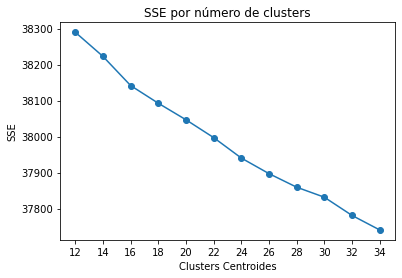

In [33]:
find_best_number_clusters(34, svd_transform)

### Vizualizar as palavras mais importantes dos clusters para os 40000 dados das criticas IMBD

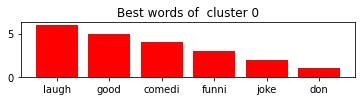

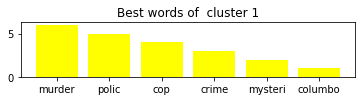

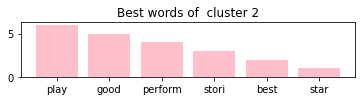

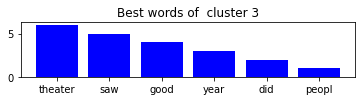

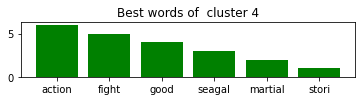

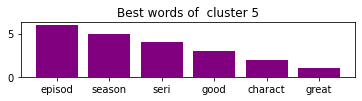

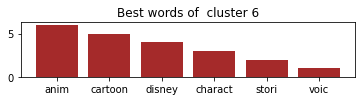

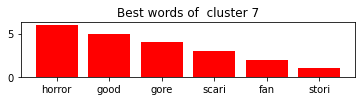

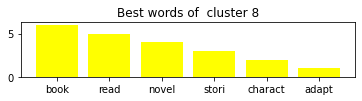

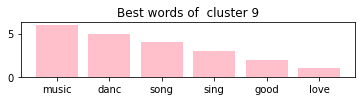

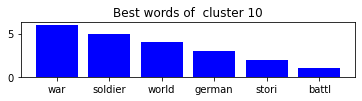

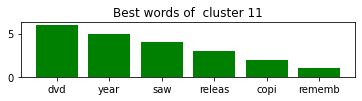

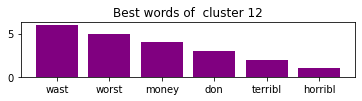

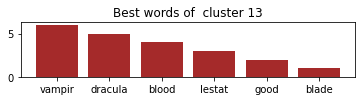

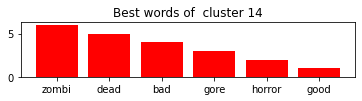

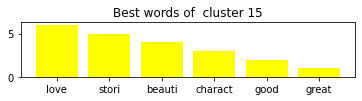

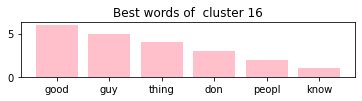

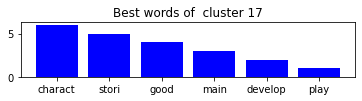

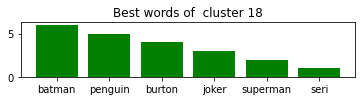

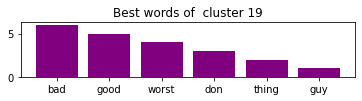

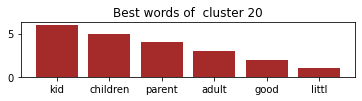

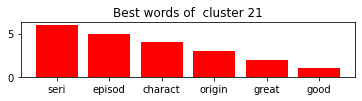

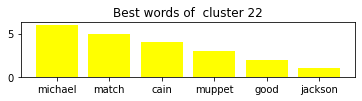

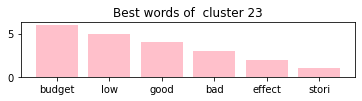

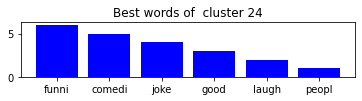

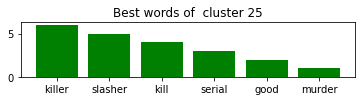

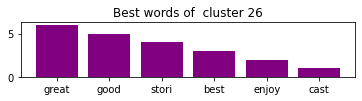

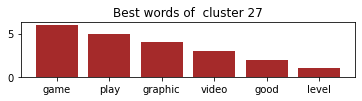

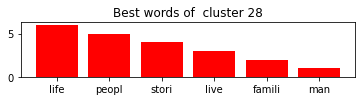

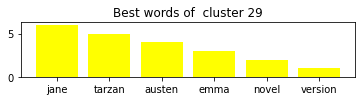

In [53]:
 showTopWords(dicMostImportantWordsData)

# Realizar a classificação dos dados binário e multi-classe

Nesta parte do trabalho é apresentado como foi feito o processo de treino dos diferentes classificadores, e o uso do RandomizedSearchCV para testar os melhores parametros.

Treinar dados de treino e de teste

In [28]:

docsTrainPreProcessed=clearText(docsTrain)
docsTestPreProcessed=clearText(docsTest)



Fazer o treino tfidf

In [30]:
tfidf=TfidfVectorizer(min_df=2,token_pattern=r'\b\w+\b',ngram_range=(1,2)).fit(docsTrainPreProcessed)


Obter a matriz documento/termo (matrizX) para treino e teste

In [33]:
 #transformacao tfidf com train e teste
x1 = text2VectorTeste(docsTrainPreProcessed,tfidf)
x2 = text2VectorTeste(docsTestPreProcessed,tfidf)

### Métodos usados para o processo de treino dos classificadores:

In [43]:
def text2VectorTeste(tfidf_fit, tfidf):
        
        
    X=tfidf.transform(tfidf_fit) #matriz documento / termo
    
    
    return X
    

In [44]:

def binClassifyTeste(X, yTrain):
    #Logistic Regression binario
    dl=LogisticRegression(penalty='l2',max_iter=1000,solver='saga',C=3.4,tol=1e-3)
    dl.fit(X,yTrain)
    
    
    return dl

In [45]:

def multiClassifyTeste(X, y):
    
    #Logistic Regression multiclasse
    dl=LogisticRegression(penalty='l1',solver='saga',max_iter=1000,C=2.1,tol=1e-3,multi_class='ovr')
    dl.fit(X,y)
    return dl

In [46]:
def multiRidge(X,y):
    
    #MultiClasse Ridge
    ridge = RidgeClassifier(alpha=1.8).fit(X, y)
    
    
    return ridge
    

In [47]:
def binClassifyBernoulli(X,yTrain):
    
    #Binario Bernoulli
    clf = BernoulliNB(fit_prior=True, alpha=1.28 )
    clf.fit(X, yTrain)
    return clf

### Classificacao Binaria logistic Regression

In [37]:
#Classificacao binaria 

yTrainBin = transformYtoBinary(yTrain)
yTestBin = transformYtoBinary(yTest)


binClass = binClassifyTeste(x1,yTrainBin)

ypredbinClass = binClass.predict(x2)


print("Treino classificacao binaria",binClass.score(x1,yTrainBin))
print("Teste classificacao binaria",binClass.score(x2,yTestBin))

#print(ypredbinClass)



Treino classificacao binaria 0.9860666666666666
Teste classificacao binaria 0.9113


### Classificacao MultiClasse Logistic Regression

In [40]:
#Classificacao multiclasse


dlMulti = multiClassifyTeste(x1,yTrain)
ypredClass = dlMulti.predict(x2)

print("Treino classificacao Multiclasse",dlMulti.score(x1,yTrain))
print("Teste classificacao Multiclasse",dlMulti.score(x2,yTest))


Treino classificacao Multiclasse 0.5976
Teste classificacao Multiclasse 0.4789


In [41]:
print("Treino classificacao Multiclasse",dlMulti.score(x1,yTrain))
print("Teste classificacao Multiclasse",dlMulti.score(x2,yTest))

Treino classificacao Multiclasse 0.5976
Teste classificacao Multiclasse 0.4789


In [42]:
yPred = dlMulti.predict(x2)
#obter matriz de confusão
print (confusion_matrix(yTest, yPred))

[[1715   74   86   91   25   23   13   93]
 [ 494  158   83  121   20   17    9   48]
 [ 339   63  216  216   51   30    7   70]
 [ 229   59  137  388   87   59    9   84]
 [  39   11   28   77  318  157   39  213]
 [  45    7   11   63  177  307   58  429]
 [  35    5   10   38   73  139  139  501]
 [  88    8    9   40   73  138   63 1548]]


### Classificação multiClasse Ridge

In [69]:
#MULTI CLASS CLASSIFICATION RIDGE 

multiClassRidge = multiRidge(x1,yTrain)




In [70]:
#O QUE O SCORE FAZ É ISTO
p = multiClassRidge.predict(x2)
#accuracy = metrics.accuracy_score(yTest,ypredClass)
#print("ACURACY",accuracy)

print("Treino classificacao ridge",multiClassRidge.score(x1,yTrain))
print("Teste classificacao ridge",multiClassRidge.score(x2,yTest))


Treino classificacao ridge 0.9656666666666667
Teste classificacao ridge 0.4785


### Classificação multiClasse Ridge

Classificacao binaria bernoli

In [ ]:
#BINARY CLASSIFICATION BERNOLI

yTrainBin = transformYtoBinary(yTrain)
yTestBin = transformYtoBinary(yTest)

binClassBernoulli = binClassifyBernoulli(x1,yTrainBin)

ypredBernoli = binClassBernoulli.predict(x2)

print("Treino classificacao binaria bernoli",binClassBernoulli.score(x1,yTrainBin))
print("Teste classificacao binaria bernoli",binClassBernoulli.score(x2,yTestBin))


# Randomized Search

De modo a descobrir os melhores parâmetros para o discriminante logístico recorreu-se ao uso do RandomizedSearchCV. 

RandomizedSearchCV percorre de forma aleatória um conjunto de hyper parâmetros e calcula o score, medida de acurácia dos métodos de predição, retornando o melhor conjunto de parâmetros consoante o score. 

Foram realizados multiplos teste de modo a obter as melhores combinações de parametros para os diversos classificadores


In [ ]:
X=clearText(docs)


In [ ]:
ybin = transformYtoBinary(y)

In [ ]:

#pipeline o modelo que queremos que seja testado
pipeline =Pipeline([
    ('tfidf' , TfidfVectorizer(min_df = 3, token_pattern=r'\b\w\w\w+\b' )),
    ('logReg' , LogisticRegression(penalty='l1',solver='saga',max_iter=1000,C=1,tol=1e-3,multi_class='ovr'))
     ])

pipelineBayes =Pipeline([
    ('tfidf' , TfidfVectorizer(min_df = 3, token_pattern=r'\b\w\w\w+\b', ngram_range=(1,3))),
    ('bayes' , BernoulliNB(fit_prior=False, alpha=1.0))
     ])

pipelineRidge =Pipeline([
    ('tfidf' , TfidfVectorizer(min_df = 3, token_pattern=r'\b\w\w\w+\b',ngram_range=(1,2))),
    ('ridge' , RidgeClassifier(alpha=1.8))
     ])


pipelineMuli =Pipeline([
    ('tfidf' , TfidfVectorizer(min_df = 3, token_pattern=r'\b\w\w\w+\b', ngram_range=(1,2) ) ),
    ('multi' ,MultinomialNB(fit_prior=False, alpha=1.7))
     ])


#passado o dicionário de parâmetros que queremos que seja testado
parameters  ={

    #'tfidf_token_pattern'=r'\b\w\w\w+b',
   # 'tfidf__min_df' : np.arange(1, 5, 1),
    #'tfidf__norm' : ['l1', 'l2'],
    'logReg__C' : np.linspace(0.5, 3, 20),
   # 'logReg__penalty' : ['l1','l2']  
}

parametersBayes  ={

    #'tfidf_token_pattern'=r'\b\w\w\w+b',

    #'tfidf__norm' : ['l1', 'l2'],
    'bayes__alpha' : np.linspace(0, 3, 15),
}

parametersMulti = {
    
    'multi__alpha' : np.linspace(0, 3, 15)
}

parametersRidge  ={

    #'tfidf_token_pattern'=r'\b\w\w\w+b',

    #'tfidf__norm' : ['l1', 'l2'],
    'ridge__alpha' : np.linspace(0, 3, 15),    
}



#grid_search=RandomizedSearchCV(pipeline, parameters, cv = 3, n_jobs=-1, verbose=3,pre_dispatch=8,n_iter = 4 ).fit(X,y)

grid_search=RandomizedSearchCV(pipelineRidge, parametersRidge, cv = 3, n_jobs=2, verbose=3,pre_dispatch=8,n_iter = 4 ).fit(X,y)






In [ ]:

print(" Resultados " )
print("\n O melhor estimator\n", grid_search.best_estimator_)
print("\n o melhor score\n", grid_search.best_score_)
print("\n Os melhores parametros\n", grid_search.best_params_)
print(grid_search.best_index_)
